In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('xente').getOrCreate()
spark

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark.sql.functions as F
import shap
import catboost
from catboost import CatBoostClassifier, Pool
from pyod.models.lscp import LSCP
from pyod.models.knn import KNN

from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                              f1_score, precision_score, recall_score, roc_curve, roc_auc_score)
from pyspark.sql.functions import (mean, dayofmonth, hour, dayofweek,
                                                                   month, weekofyear, dayofyear,
                                                                   format_number, col)
from pyspark.ml.feature import StringIndexer

In [3]:
def read_data_from_web(url):
  data = pd.read_csv(url)
  spark_data = spark.createDataFrame(data)
  return spark_data

#fraud_data = spark.read.csv('training.csv', header=True, inferSchema=True)
fraud_data = read_data_from_web("https://drive.google.com/uc?export=download&id=1NrtVkKv8n_g27w5elq9HWZA1i8aFBW0G")
df_backup = fraud_data

In [4]:
fraud_data = df_backup

### Engenharia de features

In [15]:
def remove_feature(data, columns_in):
  return data.drop(*columns_in)

def clean_data(fraud_data, columns_to_remove):
  fraud_data = remove_feature(fraud_data, columns_to_remove)
  return fraud_data

In [16]:
contamination = (fraud_data.filter('FraudResult==1').count())/(fraud_data.count())

In [17]:
fraud_data = fraud_data.withColumn("Operation", F.when(fraud_data.Amount > 0, 1).when(fraud_data.Amount < 0, -1).otherwise(0))

fraud_data = fraud_data.withColumn('Hour', hour(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('DayOfWeek', F.dayofweek(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('DayOfYear', dayofyear(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('WeekOfYear', weekofyear(fraud_data['TransactionStartTime']))

fraud_data = fraud_data.withColumn('Vl_per_weekYr', ( fraud_data['Value']/fraud_data['WeekOfYear'] ) )
fraud_data = fraud_data.withColumn('Vl_per_dayWk', ( fraud_data['Value']/fraud_data['DayOfWeek'] ) )
fraud_data = fraud_data.withColumn('Vl_per_dayYr', ( fraud_data['Value']/fraud_data['DayOfYear'] ) )

In [18]:
items_list = ['ProductId','ProviderId']
gen_train_data = fraud_data

for item in items_list:
    mean_column_name = 'avg_vl_{0}'.format(item)

    mean_aux = gen_train_data.select([item,'Value']).groupBy(item).mean()
    mean_aux = mean_aux.select(col(item), col('avg(Value)').alias(mean_column_name))

    fraud_data = fraud_data.join(mean_aux, on=item)
    
    ratio_column_name = 'Rt_avg_vl_{0}'.format(item)
    fraud_data = fraud_data.withColumn(ratio_column_name, (F.col('Value')-F.col(mean_column_name))/ F.col(mean_column_name))

In [19]:
fraud_data = clean_data(fraud_data, columns_to_remove = ['CurrencyCode','CountryCode','AccountId','SubscriptionId','CustomerId','TransactionStartTime','Amount','DayOfYear','avg_vl_ProductId','avg_vl_ProviderId'])

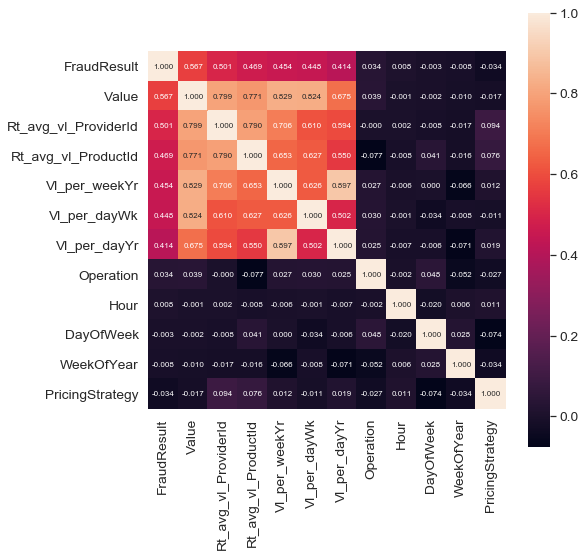

In [20]:
fraud_data_toCorr = fraud_data.toPandas()
corr_matrix = fraud_data_toCorr.corr()
k = 15 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'FraudResult')['FraudResult'].index
cm = np.corrcoef(fraud_data_toCorr[cols].values.T)
sns.set(font_scale=1.25,rc={'figure.figsize':(8, 8)})
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [22]:
all_features = ['ProviderId','ProductId','TransactionId','BatchId',
                            'ProductCategory','ChannelId','PricingStrategy',
                            'Value','Operation','Hour','DayOfWeek','WeekOfYear',
                            'Vl_per_weekYr','Vl_per_dayWk','Vl_per_dayYr',
                            'Rt_avg_vl_ProductId','Rt_avg_vl_ProviderId']

label = 'FraudResult'

categorical_features = ['ProviderId','ProductId','TransactionId','BatchId',
                            'ProductCategory','ChannelId','PricingStrategy']

numerical_features = ['Value','Operation','Hour','DayOfWeek','WeekOfYear',
                           'Vl_per_weekYr','Vl_per_dayWk','Vl_per_dayYr',
                           'Rt_avg_vl_ProductId','Rt_avg_vl_ProviderId']

In [23]:
contamination

0.00201752001839811

### split data

In [24]:
fraud_data = fraud_data.toPandas()
X_train = fraud_data[all_features]
y_train = fraud_data[label]

In [25]:
X_outliers = fraud_data[fraud_data['FraudResult'].isin([1])]

In [26]:
X_train_toTrain = X_train[numerical_features]
X_outliers_toTrain = X_outliers[numerical_features]

### Isolation Forest

In [27]:
if_clf = IsolationForest(behaviour='new',random_state=42, contamination=contamination, n_jobs=10)

In [28]:
if_clf.fit(X_train_toTrain, y_train)

IsolationForest(behaviour='new', bootstrap=False,
                contamination=0.00201752001839811, max_features=1.0,
                max_samples='auto', n_estimators=100, n_jobs=10,
                random_state=42, verbose=0, warm_start=False)

In [29]:
predictions_if = if_clf.predict(X_train[numerical_features])

In [30]:
X_train_if = X_train
X_train_if['IsolationForest'] = predictions_if

In [31]:
X_train_if = X_train_if.replace({'IsolationForest' : -1}, 0)

### LSCP

In [32]:
from pyod.models.lof import LOF
detector_list = [LOF(contamination=contamination, n_jobs=10), LOF(contamination=contamination, n_jobs=10)]

In [33]:
lscp_clf = LSCP(detector_list=detector_list, random_state=42, contamination=contamination)

In [34]:
lscp_clf.fit(X_train_toTrain)

/home/dunfrey/anaconda3/lib/python3.7/site-packages/pyod/models/lscp.py:371: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  "The number of histogram bins is greater than the number of "
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()


LSCP(contamination=0.00201752001839811,
   detector_list=[LOF(algorithm='auto', contamination=0.00201752001839811, leaf_size=30,
  metric='minkowski', metric_params=None, n_jobs=10, n_neighbors=20, p=2), LOF(algorithm='auto', contamination=0.00201752001839811, leaf_size=30,
  metric='minkowski', metric_params=None, n_jobs=10, n_neighbors=20, p=2)],
   local_max_features=1.0, local_region_size=30, n_bins=2,
   random_state=<mtrand.RandomState object at 0x7f0381830dc8>)

In [35]:
predictions_lscp = lscp_clf.predict(X_train[numerical_features])

/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()


In [36]:
X_train_if_lscp = X_train_if
X_train_if_lscp['LSCP'] = predictions_lscp

### knn

In [37]:
knn_clf = KNN(n_jobs=10, contamination=contamination,n_neighbors=2,method='mean')

In [38]:
knn_clf.fit(X_train_toTrain, y_train)

/home/dunfrey/anaconda3/lib/python3.7/site-packages/pyod/models/base.py:344: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


KNN(algorithm='auto', contamination=0.00201752001839811, leaf_size=30,
  method='mean', metric='minkowski', metric_params=None, n_jobs=10,
  n_neighbors=2, p=2, radius=1.0)

In [39]:
predictions_knn = knn_clf.predict(X_train[numerical_features])

In [40]:
X_train_if_lscp_knn = X_train_if_lscp
X_train_if_lscp_knn['Knn'] = predictions_knn

#### New Feature: CountDetection | PercentDetection

In [41]:
final_data = X_train_if_lscp_knn

In [42]:
final_data[ 'CountDetection'] = (final_data.IsolationForest + final_data.LSCP + final_data.Knn)

In [43]:
final_data['PercentDetection'] = (100 * ((final_data.IsolationForest + final_data.LSCP + final_data.Knn)/3)).astype(int)

### Adding features to the dataframe

In [44]:
categorical_features.append('IsolationForest')
categorical_features.append('LSCP')
categorical_features.append('Knn')
categorical_features.append('CountDetection')
categorical_features.append('PercentDetection')

all_features.append('IsolationForest')
all_features.append('LSCP')
all_features.append('Knn')
all_features.append('CountDetection')
all_features.append('PercentDetection')

In [45]:
categorical_features_dims = [final_data.columns.get_loc(i) for i in categorical_features[:]] 
numerical_features_dims = [final_data.columns.get_loc(i) for i in numerical_features[:]] 

### Balanceando

In [46]:
X_train = final_data[all_features]

In [47]:
sm = SMOTENC(categorical_features=categorical_features_dims, random_state = 42, n_jobs=10)

In [48]:
 X_smotenc, y_smotenc = sm.fit_sample(X_train[all_features], y_train)

In [49]:
X_smotenc = pd.DataFrame(X_smotenc, columns=all_features)
y_smotenc = pd.DataFrame(y_smotenc, columns=[label])

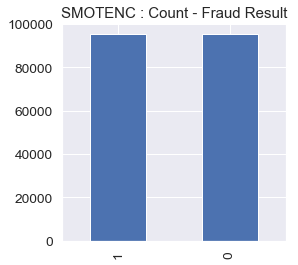

In [50]:
sns.set(font_scale=1.25,rc={'figure.figsize':(4, 4)})
pd.Series(y_smotenc[label]).value_counts().plot.bar(title='SMOTENC : Count - Fraud Result')

### CatBoost

In [98]:
model = CatBoostClassifier(depth=5,learning_rate=0.1,l2_leaf_reg=1,eval_metric='F1',random_seed=42)
model.fit(X_smotenc, y_smotenc, verbose=False, plot=True, cat_features=categorical_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [53]:
shap.initjs()

shap_values = model.get_feature_importance(Pool(X_smotenc, y_smotenc, cat_features=categorical_features_dims), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[200,:], X_smotenc.iloc[200,:])

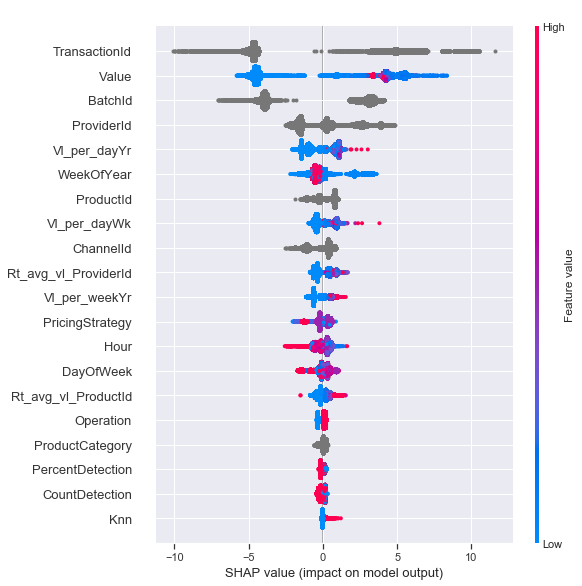

In [54]:
shap.initjs()
# summarize the effects of all the features
shap.summary_plot(shap_values, X_smotenc)

### Avaliacao

In [55]:
#test_data = read_data_from_web("https://drive.google.com/uc?export=download&id=16cRQIFW6n2th2YOK7DEsp9dQgihHDuHa")
test_data = spark.read.csv('../data/xente_fraud_detection_test.csv', header=True, inferSchema=True)
test_backup = test_data

In [62]:
test_data = test_backup

In [63]:
test_data = test_data.withColumn("Operation", F.when(test_data.Amount > 0, 1).when(test_data.Amount < 0, -1).otherwise(0))

test_data = test_data.withColumn('Hour', hour(test_data['TransactionStartTime']))
test_data = test_data.withColumn('DayOfWeek', F.dayofweek(test_data['TransactionStartTime']))
test_data = test_data.withColumn('DayOfYear', dayofyear(test_data['TransactionStartTime']))
test_data = test_data.withColumn('WeekOfYear', weekofyear(test_data['TransactionStartTime']))

test_data = test_data.withColumn('Vl_per_weekYr', ( test_data['Value']/test_data['WeekOfYear'] ) )
test_data = test_data.withColumn('Vl_per_dayWk', ( test_data['Value']/test_data['DayOfWeek'] ) )
test_data = test_data.withColumn('Vl_per_dayYr', ( test_data['Value']/test_data['DayOfYear'] ) )

In [64]:
items_list = ['ProductId','ProviderId']
gen_train_data = test_data

for item in items_list:
    mean_column_name = 'avg_vl_{0}'.format(item)

    mean_aux = gen_train_data.select([item,'Value']).groupBy(item).mean()
    mean_aux = mean_aux.select(col(item), col('avg(Value)').alias(mean_column_name))

    test_data = test_data.join(mean_aux, on=item)
    
    ratio_column_name = 'Rt_avg_vl_{0}'.format(item)
    test_data = test_data.withColumn(ratio_column_name, (F.col('Value')-F.col(mean_column_name))/ F.col(mean_column_name))

In [65]:
test_data = clean_data(test_data, columns_to_remove = ['CurrencyCode','CountryCode','AccountId','SubscriptionId','CustomerId','TransactionStartTime','Amount','DayOfYear','avg_vl_ProductId','avg_vl_ProviderId'])

In [66]:
all_features = ['ProviderId','ProductId','TransactionId','BatchId',
                            'ProductCategory','ChannelId','PricingStrategy',
                            'Value','Operation','Hour','DayOfWeek','WeekOfYear',
                            'Vl_per_weekYr','Vl_per_dayWk','Vl_per_dayYr',
                            'Rt_avg_vl_ProductId','Rt_avg_vl_ProviderId']

label = 'FraudResult'

categorical_features = ['ProviderId','ProductId','TransactionId','BatchId',
                            'ProductCategory','ChannelId','PricingStrategy']

numerical_features = ['Value','Operation','Hour','DayOfWeek','WeekOfYear',
                           'Vl_per_weekYr','Vl_per_dayWk','Vl_per_dayYr',
                           'Rt_avg_vl_ProductId','Rt_avg_vl_ProviderId']

In [67]:
test_data = test_data.toPandas()
X_test = test_data[all_features]

In [68]:
categorical_features_dims = [X_test.columns.get_loc(i) for i in categorical_features[:]] 
numerical_features_dims = [X_test.columns.get_loc(i) for i in numerical_features[:]] 

In [69]:
predictions_if = if_clf.predict(X_test[numerical_features])
X_test['IsolationForest'] = predictions_if

/home/dunfrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
X_test = X_test.replace({'IsolationForest' : -1}, 0)

In [71]:
X_test_if = X_test

In [72]:
predictions_lscp = lscp_clf.predict(X_test[numerical_features])
X_test_if['LSCP'] = predictions_lscp

/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [73]:
X_test_if_lscp = X_test_if

In [74]:
predictions_knn = knn_clf.predict(X_test[numerical_features])
X_test_if_lscp['Knn'] = predictions_knn

In [75]:
final_test_data = X_test_if_lscp

In [76]:
final_test_data[ 'CountDetection'] = (final_test_data.IsolationForest + final_test_data.LSCP + final_test_data.Knn)
final_test_data['PercentDetection'] = (100 * ((final_test_data.IsolationForest + final_test_data.LSCP + final_test_data.Knn)/3)).astype(int)

In [94]:
final_result = model.predict( final_test_data )

In [78]:
def save_predictions_xente(file_name, transactions_list, predictions_list):
    file = open(file_name,'w')
    file.write('TransactionId,FraudResult\n')
    for (trans_id, value) in zip(transactions_list, predictions_list):
        file.write('{0},{1}\n'.format(trans_id, int(value)))
    file.close()

In [95]:
X_test = test_backup.toPandas()
output_file = 'xente_predictions.txt'  
X_test_transactions_list = list(X_test['TransactionId'])

In [96]:
save_predictions_xente(output_file, X_test_transactions_list, final_result)

In [97]:
print("Concluido")

Concluido
